In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
np.set_printoptions(precision=4, suppress=True)

# Data-Driven Modeling And Machine Learning Assignment 2

## Q1 (25 points): Outlier Detection and Removal using Cook’s Distance
### 1.1 Model choice and justification

The model I chose for implementing Cook’s Distance outlier detection is linear regression with the library of statsmodels OLS. It's because Cook's distance is used and derived for OLS linear regression problems. Using ridge or lasso will cause problems, for example ridge and lasso has regularization terms, which will break the OLS assumptions. Also using statsmodels is better than scikit-learn in this case because scikit-learn doesn't havestandard errors or influence components, you have to compute it manually. 

### 1.2 Identify outliers, remove them, and export clean CSV

In [121]:
df = pd.read_csv("usina_with_outliers.csv")   
y = df['PE']
X = df.drop(columns=['PE'])
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

influence = model.get_influence()
cooksDistance = influence.cooks_distance[0]

df['cooks_distance'] = cooksDistance

threshold = 4 / len(df)
df_clean = df[df['cooks_distance'] <= threshold].copy()
df_clean.drop(columns=['cooks_distance'], inplace=True)
df_clean.to_csv("usina.csv", index=False)

## Q2 Train/Test Evaluation Before vs After Outlier Removal

### For usina with outliers.csv

In [125]:
df = pd.read_csv("usina_with_outliers.csv")


X = df.drop(columns=['PE']).copy()
y = df['PE'].values.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, shuffle=True
)

lambdas = [0.01, 0.1, 1, 10, 100]

def eval_metrics(y_true, y_pred):
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)
    return {
        "mse": mean_squared_error(y_true, y_pred),
        "mae": mean_absolute_error(y_true, y_pred),
        "r2":  r2_score(y_true, y_pred),
    }
    

def fit_and_report_basic_models():
    models = {
        "Linear": LinearRegression(),
        "Ridge(alpha=1.0)": Ridge(alpha=1.0, random_state=42),
        "Lasso(alpha=1.0)": Lasso(alpha=1.0, max_iter=50000, random_state=42),
    }

    rows = []

    lin = LinearRegression()
    lin.fit(X_train, y_train.ravel())

    pred_tr = lin.predict(X_train).reshape(-1, 1)
    pred_te = lin.predict(X_test).reshape(-1, 1)

    mtr = eval_metrics(y_train, pred_tr)
    mte = eval_metrics(y_test, pred_te)

    rows.append({
        "model": "Linear Regression",
        **{f"train_{k}": v for k, v in mtr.items()},
        **{f"test_{k}": v for k, v in mte.items()},
    })

    for lam in lambdas:
        ridge = Ridge(alpha=lam, random_state=42)
        ridge.fit(X_train, y_train.ravel())

        pred_tr = ridge.predict(X_train).reshape(-1, 1)
        pred_te = ridge.predict(X_test).reshape(-1, 1)

        mtr = eval_metrics(y_train, pred_tr)
        mte = eval_metrics(y_test, pred_te)

        rows.append({
            "model": f"Ridge (λ={lam})",
            **{f"train_{k}": v for k, v in mtr.items()},
            **{f"test_{k}": v for k, v in mte.items()},
        })

    for lam in lambdas:
        lasso = Lasso(alpha=lam, max_iter=50000, random_state=42)
        lasso.fit(X_train, y_train.ravel())

        pred_tr = lasso.predict(X_train).reshape(-1, 1)
        pred_te = lasso.predict(X_test).reshape(-1, 1)

        mtr = eval_metrics(y_train, pred_tr)
        mte = eval_metrics(y_test, pred_te)

        rows.append({
            "model": f"Lasso (λ={lam})",
            **{f"train_{k}": v for k, v in mtr.items()},
            **{f"test_{k}": v for k, v in mte.items()},
        })

    return pd.DataFrame(rows)

outlierResults = fit_and_report_basic_models()
display(outlierResults)


,model,train_mse,train_mae,train_r2,test_mse,test_mae,test_r2
0,Linear Regression,123.384207,5.198679,0.650171,125.113389,5.052458,0.642574
1,Ridge (λ=0.01),123.384207,5.198679,0.650171,125.113389,5.052458,0.642574
2,Ridge (λ=0.1),123.384207,5.198680,0.650171,125.113392,5.052459,0.642574
3,Ridge (λ=1),123.384207,5.198685,0.650171,125.113421,5.052463,0.642574
4,Ridge (λ=10),123.384207,5.198737,0.650171,125.113705,5.052513,0.642573
5,Ridge (λ=100),123.384213,5.199261,0.650171,125.116548,5.053003,0.642565
6,Lasso (λ=0.01),123.384210,5.198858,0.650171,125.115332,5.052626,0.642568
7,Lasso (λ=0.1),123.384607,5.201739,0.650169,125.134495,5.055348,0.642514
8,Lasso (λ=1),123.421151,5.229507,0.650066,125.338356,5.083092,0.641931
9,Lasso (λ=10),126.141514,5.540418,0.642353,128.902136,5.408803,0.631750


### For usina.csv

In [128]:
df = pd.read_csv("usina.csv")


X = df.drop(columns=['PE']).copy()
y = df['PE'].values.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, shuffle=True
)

lambdas = [0.01, 0.1, 1, 10, 100]

noOutlierResults = fit_and_report_basic_models()
display(noOutlierResults)


,model,train_mse,train_mae,train_r2,test_mse,test_mae,test_r2
0,Linear Regression,19.864671,3.596396,0.931369,20.396772,3.624773,0.930302
1,Ridge (λ=0.01),19.864671,3.596396,0.931369,20.396772,3.624773,0.930302
2,Ridge (λ=0.1),19.864671,3.596397,0.931369,20.396770,3.624773,0.930302
3,Ridge (λ=1),19.864671,3.596400,0.931369,20.396750,3.624774,0.930302
4,Ridge (λ=10),19.864672,3.596430,0.931369,20.396549,3.624783,0.930303
5,Ridge (λ=100),19.864758,3.596742,0.931369,20.394626,3.624880,0.930310
6,Lasso (λ=0.01),19.864675,3.596368,0.931369,20.396738,3.624754,0.930302
7,Lasso (λ=0.1),19.865263,3.596855,0.931367,20.392600,3.624890,0.930316
8,Lasso (λ=1),19.929852,3.605523,0.931144,20.414755,3.631153,0.930241
9,Lasso (λ=10),25.685683,4.086632,0.911258,26.157253,4.120464,0.910618


## Discussion 

The outliers changes both train error and test error. The data set without outliers shows better generalization, as it has a higher r^2 value and lower mse value for every type of regression. There's lower r^2 value and higher mse value for every type of regression when theres outliers present. Ridge and lasso does not help relative to standard linear regression, in the set without outliers, Ridge and lasso has similar performance compared to linear regression. 

## Q3 Reliability of Coefficients (Use Outlier-Removed Dataset)

### 3.1 Method choice and scaling decision  

The model we use is linear regression. Using ridge or lasso will cause problems, for example ridge and lasso has regularization terms, it will introduce bias in coefficient estimation. The library we used to investigate the reliability of regression coefficients is Statsmodels OLS, instead of Scikit-learn. It's because we need to use Ordinary Least Squares to compute studentized coefficients. The studentized coefficients is needed to see whether or not the coefficient is statistically distinguishable from 0. For this task I will scale the IVs, as scaling IVs can improve comparability, and scaling DVs will not change anything. However, scaling IVs or DVs does not impact this question, as t-value will not change from scaling. 

### 3.2 — Implementation and results

In [136]:

df = pd.read_csv("usina.csv")
X = df.drop(columns=['PE']).copy()
y = df['PE'].values.reshape(-1, 1)


scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

ols_scaled = sm.OLS(y, sm.add_constant(X_scaled)).fit()
print(ols_scaled.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                 3.188e+04
Date:                Thu, 29 Jan 2026   Prob (F-statistic):               0.00
Time:                        11:56:29   Log-Likelihood:                -27563.
No. Observations:                9448   AIC:                         5.514e+04
Df Residuals:                    9443   BIC:                         5.517e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        454.2997      0.046   9865.884      0.0

#### From the table above, the most reliable coefficient is AT at 129.113, as it has the highest absolute t-statistic, and the least reliable coefficient is AP at 7.895, as it has the lowest absolute t-statistic.  

## Q4 Most Important vs Least Important Features (Use Outlier-Removed Dataset)

### 4.1 Method choice and scaling decision  

The model I select to determine the most important and least important feature is linear regression. Linear regression is used in this case, because importance is determined by the magnitude of each feature’s effect on the output. Using ridge and lasso will have regularization, which impacts the magnitude of the coefficients, making interpretations biased. The library we used to investigate the reliability of regression coefficients is Statsmodels OLS, instead of Scikit-learn. It's because we need to use Ordinary Least Squares to compute studentized coefficients. The studentized coefficients is needed to see whether or not the coefficient is statistically distinguishable from 0.  For this task I will scale the IVs, as scaling IVs can improve comparability of the coefficient magnitudes, feature importance can be highlighted and not unit differences. Scaling DVs will not change anything. 

### 4.2 — Implementation and results

In [143]:

df = pd.read_csv("usina.csv")
X = df.drop(columns=['PE']).copy()
y = df['PE'].values.reshape(-1, 1)


scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

ols_scaled = sm.OLS(y, sm.add_constant(X_scaled)).fit()
print(ols_scaled.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                 3.188e+04
Date:                Thu, 29 Jan 2026   Prob (F-statistic):               0.00
Time:                        11:56:30   Log-Likelihood:                -27563.
No. Observations:                9448   AIC:                         5.514e+04
Df Residuals:                    9443   BIC:                         5.517e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        454.2997      0.046   9865.884      0.0

#### From the table above, the most important feature is AT, as it has the largest absolute coefficient at 14.5566, and the least important feature is AP, as it has the smallest absolute coefficient at 0.4425.  

## Q5 Regularization Paths (Scaled Data, Outlier-Removed Dataset)

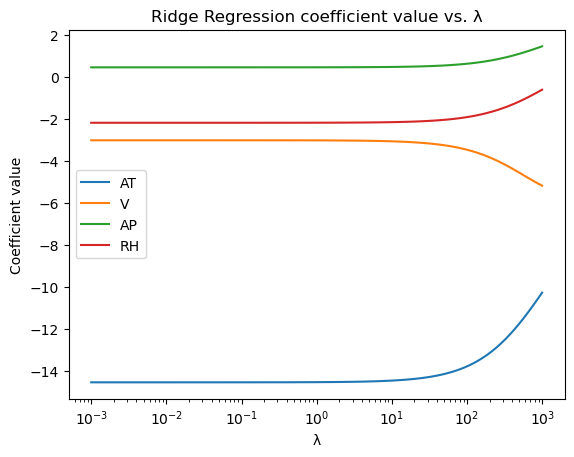

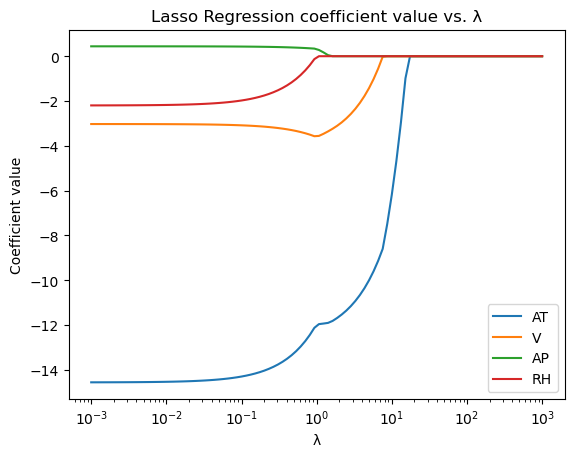

In [147]:
df = pd.read_csv("usina.csv")
X = df.drop(columns=['PE']).copy()
y = df['PE'].values.reshape(-1, 1)


scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
feature_names = X.columns

lambdas = np.logspace(-3, 3, 100)

ridge_coefs = []
for lam in lambdas:
    ridge = Ridge(alpha=lam, random_state=42)
    ridge.fit(X_scaled, y.ravel())
    ridge_coefs.append(ridge.coef_)
    
ridge_coefs = np.array(ridge_coefs)

lasso_coefs = []
for lam in lambdas:
    lasso = Lasso(alpha=lam, max_iter=50000, random_state=42)
    lasso.fit(X_scaled, y.ravel())
    lasso_coefs.append(lasso.coef_)

lasso_coefs = np.array(lasso_coefs)



for i, name in enumerate(feature_names):
    plt.plot(lambdas, ridge_coefs[:, i], label=name)

plt.xscale("log")
plt.xlabel("λ")
plt.ylabel("Coefficient value")
plt.title("Ridge Regression coefficient value vs. λ")
plt.legend()
plt.show()

 
for i, name in enumerate(feature_names):
    plt.plot(lambdas, lasso_coefs[:, i], label=name)

plt.xscale("log")
plt.xlabel("λ")
plt.ylabel("Coefficient value")
plt.title("Lasso Regression coefficient value vs. λ")
plt.legend()
plt.show()


### Discussion 
#### When λ increases in Ridge, the value of coefficient begins to change, may increase or decreases. Howewver, when λ increases in lasso, all the feature's coefficient eventually becomes the same. The feature that is better for multicollinearity in IVs is Ridge regression, as Ridge stabilizes the coefficients. However, the feature that is better for feature selection is Lasso, as Lasso removes unimportant features by shrinking their coefficient to 0.   